In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

data_URL = '/Users/kristivanmeter/Desktop/MIDS/Capstone/merged_names.csv'
df = pd.read_csv(data_URL, encoding = "ISO-8859-1")
df.head()

,Unnamed: 0.1,Unnamed: 0,block_order,block_name,stimuli,valence,random_fixation,movement,accuracy,response_time,...,Avg Total RT Avoid Black,Avg Total RT Approach White,Avg Total RT Avoid White,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism,white_black,diversity_index
0,0,10,1,blkTestCatAAp,40,1,1200,Avoid,1,653,...,705.3,906.700,721.8,4.00,3.75,3.00,3.50,3.00,197.511628,0.102805
1,40,110,1,blkTestCatAAp,61,2,1900,Approach,1,6601,...,1192.5,1236.200,1417.3,3.50,4.00,4.25,3.25,2.50,2.708221,0.589204
2,80,210,1,blkTestCatAAp,34,1,1900,Avoid,1,1262,...,1028.0,951.875,1231.5,3.50,3.50,3.25,2.25,3.00,0.267080,0.483474
3,113,310,1,blkTestCatAAp,47,2,1000,Approach,1,1895,...,694.3,761.200,735.1,3.75,4.75,4.50,4.75,2.50,0.107983,0.368624
4,153,410,1,blkTestCatAAp,49,2,1300,Approach,1,415,...,571.7,534.300,573.1,3.25,4.50,1.50,1.00,1.25,0.026607,0.138734


In [2]:
list(df.columns)

['Unnamed: 0.1',
 'Unnamed: 0',
 'block_order',
 'block_name',
 'stimuli',
 'valence',
 'random_fixation',
 'movement',
 'accuracy',
 'response_time',
 'ImpVsExp',
 'participant',
 'Group',
 'Race',
 'Gender',
 'Duration (in seconds)',
 'ResponseId',
 'Age',
 'CurrentGender',
 'Sex',
 'RaceEthnicity',
 'Check1_1',
 'Political_1',
 'Zip',
 'Occupations',
 'PSYID',
 'FTBlack_1',
 'VCNegBlack_1',
 'VCPosBlack_1',
 'ECBlack_Neighbors',
 'ECBlack_WorkColleagues',
 'ECBlack_CloseFriends',
 'ECBlack_Married',
 'FTWhite_1',
 'VCNegWhite_1',
 'VCPosWhite_1',
 'ECWhite_Neighbors',
 'ECWhite_WorkColleagues',
 'ECWhite_CloseFriends',
 'ECWhite_Married',
 'MiniIPI_1_1',
 'MiniIPI_1_2',
 'MiniIPI_1_3',
 'MiniIPI_1_4',
 'MiniIPI_1_5',
 'MiniIPI_2_1',
 'MiniIPI_2_2',
 'MiniIPI_2_3',
 'MiniIPI_2_4',
 'MiniIPI_2_5',
 'MiniIPI_3_1',
 'MiniIPI_3_2',
 'MiniIPI_3_3',
 'MiniIPI_3_4',
 'MiniIPI_3_5',
 'MiniIPI_4_1',
 'MiniIPI_4_2',
 'MiniIPI_4_3',
 'MiniIPI_4_4',
 'MiniIPI_4_5',
 'Unclear',
 'Comments ',
 're

In [3]:
df.shape

(359, 89)

In [4]:
# List of desired columns
desired_columns = ['movement', 'response_time', 'ImpVsExp','accuracy',
                   'Age', 'CurrentGender', 'RaceEthnicity', 'Race', 'Political_1',
                    'stimuli', 'accuracy_total', 'white_black','diversity_index']

# Subset the DataFrame to include only the desired columns
df_filtered = df[desired_columns].copy()

print(df_filtered.dtypes)

movement            object
response_time        int64
ImpVsExp            object
accuracy             int64
Age                  int64
CurrentGender       object
RaceEthnicity       object
Race                object
Political_1         object
stimuli              int64
accuracy_total     float64
white_black        float64
diversity_index    float64
dtype: object


### Label encode and discretize

In [5]:

df_filtered['movement'] = df_filtered['movement'].replace({'Avoid': 0, 'Approach': 1})
df_filtered['ImpVsExp'] = df_filtered['ImpVsExp'].replace({'Implicit': 0, 'Explicit': 1})

/var/folders/z2/38w7d0t53n9_7n4mywgz6phc0000gn/T/ipykernel_34196/1035857865.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtered['movement'] = df_filtered['movement'].replace({'Avoid': 0, 'Approach': 1})
/var/folders/z2/38w7d0t53n9_7n4mywgz6phc0000gn/T/ipykernel_34196/1035857865.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtered['ImpVsExp'] = df_filtered['ImpVsExp'].replace({'Implicit': 0, 'Explicit': 1})


In [6]:
df_filtered.head()
df_filtered.shape

(359, 13)

### Drop participants with accuracy < 0.7 and rt > 2500 or < 100

In [7]:
# Exclude outliers from rt
df_filtered = df_filtered.loc[df_filtered['response_time'] <= 2500, :]
df_filtered = df_filtered.loc[df_filtered['response_time'] >= 100, :]
df_filtered = df_filtered.loc[df_filtered['accuracy_total'] >= 0.70, :]
df_filtered = df_filtered.loc[df_filtered['accuracy']==1]

df_filtered.drop(columns=['accuracy_total', 'accuracy'], inplace=True)
print(df_filtered.shape)
df_filtered.head()

(321, 11)


,movement,response_time,ImpVsExp,Age,CurrentGender,RaceEthnicity,Race,Political_1,stimuli,white_black,diversity_index
0,0,653,0,58,Female,"White alone, not Hispanic or Latino",Dr.Dre,Moderate,40,197.511628,0.102805
2,0,1262,0,46,Female,Black or African American alone,Dr.Dre,Strongly conservative,34,0.267080,0.483474
3,1,1895,0,59,Female,Black or African American alone,Dr.Dre,Liberal,47,0.107983,0.368624
4,1,415,0,43,Male,Black or African American alone,Dr.Dre,Moderate,49,0.026607,0.138734
5,0,1369,0,56,Female,Black or African American alone,Dr.Dre,Liberal,48,1.359602,0.627702


### Dropna

In [8]:
df_filtered.isna().sum()

movement           0
response_time      0
ImpVsExp           0
Age                0
CurrentGender      0
RaceEthnicity      0
Race               0
Political_1        0
stimuli            0
white_black        0
diversity_index    3
dtype: int64

In [9]:
df_filtered = df_filtered.dropna()
df_filtered.isna().sum()

movement           0
response_time      0
ImpVsExp           0
Age                0
CurrentGender      0
RaceEthnicity      0
Race               0
Political_1        0
stimuli            0
white_black        0
diversity_index    0
dtype: int64

In [10]:
print(df_filtered.shape)

(318, 11)


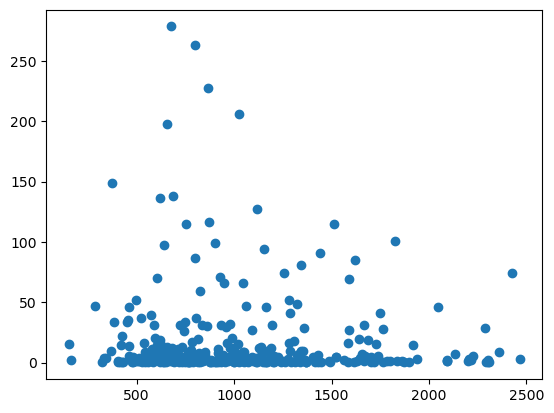

In [11]:
plt.scatter(df_filtered['response_time'], df_filtered['white_black'])

### Apply standard scaler to numerical columns

In [12]:
df_filtered['movement'] = df_filtered['movement'].astype('int')
# Convert those columns to 'category' data type
categorical_columns = ['movement', 'ImpVsExp', 'CurrentGender', 'RaceEthnicity', 'Race']

for column in categorical_columns:
    df_filtered.loc[:, column] = df_filtered[column].astype('category')

print(df_filtered.dtypes)

movement             int64
response_time        int64
ImpVsExp             int64
Age                  int64
CurrentGender       object
RaceEthnicity       object
Race                object
Political_1         object
stimuli              int64
white_black        float64
diversity_index    float64
dtype: object


In [13]:
# Print all unique age values in the dataset
age_values = df_filtered['white_black'].unique()
print("Unique age values in the dataset:")
for w in age_values:
    print(w)


Unique age values in the dataset:
197.5116279069767
0.2670804487944617
0.1079826732673267
0.0266071723682036
1.3596017549780628
4.731405649339796
1.6460146587265232
1.427628056398358
28.547884187082406
0.8357678641926569
0.1159179803247599
0.3848350415583091
0.5166803823510793
2.0441794053418443
3.0251980982567352
1.3158347676419966
0.0956671077451504
33.773371104815865
1.6041551075765983
14.703198294243071
278.6666666666667
2.5990816819719673
30.90508149568552
26.330434782608695
46.070234113712374
2.488467874794069
0.070432488457552
0.4447102013572144
1.26206257572518
1.043003046049095
7.713615023474178
12.44060773480663
0.4086010030946537
0.3301415134310652
0.2331139980878465
0.3742407901458818
0.8761543197209112
0.1525910818577918
4.68295719844358
0.6090010165419093
28.59375
0.221034787735849
6.222794959908362
0.3773823191733639
11.542657342657344
0.2631902784187048
48.875739644970416
2.3407682775712515
7.014820803018054
136.3
3.602983745268314
1.2940476190476191
34.004056795131845


In [14]:
# Replace 'inf' values with the maximum finite value in the 'white_black' column
max_finite_value = np.finfo(np.float64).max
df_filtered['white_black'] = df_filtered['white_black'].replace(np.inf, max_finite_value)

In [15]:
# Drop original 'participant' and target 'response_time' for X
X = df_filtered.drop(columns=['response_time'])
y = df_filtered['response_time']

# Scale numeric features
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

X['rt'] = y
X.to_csv('names_cleaned_scaled.csv')

/Users/kristivanmeter/opt/miniconda3/envs/capstoneenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1156: RuntimeWarning: overflow encountered in square
  temp **= 2
/Users/kristivanmeter/opt/miniconda3/envs/capstoneenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/kristivanmeter/opt/miniconda3/envs/capstoneenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/kristivanmeter/opt/miniconda3/envs/capstoneenv/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:84: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2


<bound method NDFrame.head of      Unnamed: 0.1  Unnamed: 0  block_order     block_name  stimuli  valence  \
0               0          10            1  blkTestCatAAp       40        1   
1              40         110            1  blkTestCatAAp       61        2   
2              80         210            1  blkTestCatAAp       34        1   
3             113         310            1  blkTestCatAAp       47        2   
4             153         410            1  blkTestCatAAp       49        2   
..            ...         ...          ...            ...      ...      ...   
354         13032       35410            1  blkTestCatAAp       33        1   
355         13072       35510            1  blkTestCatAAp       35        1   
356         13108       35610            1  blkTestCatAAp       49        2   
357         13147       35710            1  blkTestCatAAp       32        1   
358         13181       35810            1  blkTestCatAAp       58        2   

     random_fixation 